In [1]:
import itertools
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd

import json

from glob import glob
import os

from importlib import reload

import utils
import persim

import tifffile as tf
from KDEpy import FFTKDE
from scipy import ndimage,stats,spatial

In [2]:
nuclei_mask_cutoff = 1
seed = 42
ndims = 3
fs = 12
PP = 6
dpi = 96
minlife = 0.0
rng = np.random.default_rng(seed)
permmethod = stats.PermutationMethod(n_resamples=999, random_state=rng)

Cmap='plasma'
pxs = 75
pxbar = np.s_[-25:-5, 5:5 + pxs]
s = 50
alphaNmin = 0.1
alphaNmax = 10

wong = ['#d81b60', '#b5b5b5', '#6b6b6b', '#000000']
marker = ['D', '8', 's', '^', 'v', 'P', 'X', '*']
color = ['#56b4e9', '#f0e442', '#009e73', '#0072b2', '#d55e00', '#cc79a7', '#e69f00', '#e0e0e0', '#000000']
cmap = ['Blues_r', 'Wistia', 'Greens_r', 'BuPu_r', 'Oranges_r', 'RdPu_r', 'YlOrBr_r', 'gray', 'gist_gray']
box_params = {'widths':0.75, 'patch_artist':True, 'medianprops':{'lw':3, 'color':'red'} }
#figdst = os.path.expanduser('~') + '/documents/website/mcarto/figs/'
sample = 'D2'

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
ksrc = '../kde/'
isrc = '..' + os.sep + 'infected_focus_summer24' + os.sep 

isrc += sample + os.sep
ksrc += sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col='ndimage_cellID')
metaecc = pd.read_csv(ksrc + sample + '_nodule_root_eccentricity.csv', index_col='ndimage_cellID')
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv', index_col='gene')
cell_nuc = pd.read_csv(ksrc + sample + '_nuclei_limits.csv')

transcriptomes = np.asarray(list(metatrans['gene']))
metatrans = metatrans.set_index('gene')

Cells = utils.get_range_cell_values(isrc + 'infected_cells_ids.csv', metacell, startval=1)
Cells = np.setdiff1d( Cells, metacell[metacell['number_nuclei'] > 1].index)

Genes = utils.get_range_gene_values(isrc + 'genes_to_focus_infection.csv', transcriptomes, startval=0)
invGenes = dict(zip(Genes, range(len(Genes))))
invCells = dict(zip(Cells, range(len(Cells))))
transfocus = transcell.loc[transcriptomes[Genes], Cells.astype(str)]

level = 'sub'
normtype = 'both'
stepsize = 3
sigma = 1
pers_w = 1
pixel_size = 1

hdims = np.array([1,2])
Pname = ' [$' + ' \\oplus '.join(['H_{}'.format(k) for k in hdims]) + '$]'
pname = 'H' + '+'.join(hdims.astype(str))
SCALES = [16, 24, 32, 40, 48]
BWS = [10,15,20,25,30]

id_gene = 'GLYMA_05G203100'
full_id_gene = ''.join(id_gene)
id_gene = id_gene[-9:]

gi, gj = 0,1
pvaltol = 1e-2
o5glabels = ['All', 'w/ '+id_gene, 'w/o '+id_gene]

fivegcolumns = []
for j in [gi, gj]:
    for k in range(2):
        for t in ['KS', 'MW', 'Anderson']:
            foo = 'w_vs_wo_{}_-_PC{}_-_{}_-_{}_pval'.format(id_gene[-9:], k+1, transcriptomes[Genes[j]][-9:], t)
            fivegcolumns.append(foo)

for w in ['all', 'w_'+id_gene,'wo_'+id_gene]:
    for it in itertools.product(range(2), repeat=2):
        for t in ['rho', 'pval']:
            foo = '{}_-_{}_PC{}_-_vs_-_{}_PC{}_-_spearman_{}'.format(w, transcriptomes[Genes[gi]][-9:], it[0]+1, transcriptomes[Genes[gj]][-9:], it[1]+1, t)
            fivegcolumns.append(foo)

for w in ['all', 'w_'+id_gene,'wo_'+id_gene]:
    for j, gidx in enumerate([gi,gj]):
        for k in range(2):
            for t in ['rho', 'pval']:
                foo = '{}_-_ecc_-_vs_-_{}_PC{}_-_spearman_{}'.format(w, transcriptomes[Genes[gidx]][-9:], k+1, t)
                fivegcolumns.append(foo)
                
dfs = dict()
for scale in SCALES:
    for bw in BWS:
        foo = [len(Genes), level, normtype, stepsize, bw, scale, sigma, pers_w, pixel_size, pname]
        filename = isrc + 'G{}_{}level_{}_step{}_bw{}/scale{}_-_PI_{}_{}_{}_{}'.format(*foo)
        filename += '_{}_{}_pca_{}.csv'.format(*transcriptomes[Genes[[gi,gj]]], full_id_gene)
        dfs[(scale, bw)] = pd.read_csv(filename, header=None, names=fivegcolumns)

In [3]:
for i in range(len(fivegcolumns)):
    print(i, fivegcolumns[i], sep='\t')

0	w_vs_wo_05G203100_-_PC1_-_17G195900_-_KS_pval
1	w_vs_wo_05G203100_-_PC1_-_17G195900_-_MW_pval
2	w_vs_wo_05G203100_-_PC1_-_17G195900_-_Anderson_pval
3	w_vs_wo_05G203100_-_PC2_-_17G195900_-_KS_pval
4	w_vs_wo_05G203100_-_PC2_-_17G195900_-_MW_pval
5	w_vs_wo_05G203100_-_PC2_-_17G195900_-_Anderson_pval
6	w_vs_wo_05G203100_-_PC1_-_05G092200_-_KS_pval
7	w_vs_wo_05G203100_-_PC1_-_05G092200_-_MW_pval
8	w_vs_wo_05G203100_-_PC1_-_05G092200_-_Anderson_pval
9	w_vs_wo_05G203100_-_PC2_-_05G092200_-_KS_pval
10	w_vs_wo_05G203100_-_PC2_-_05G092200_-_MW_pval
11	w_vs_wo_05G203100_-_PC2_-_05G092200_-_Anderson_pval
12	all_-_17G195900_PC1_-_vs_-_05G092200_PC1_-_spearman_rho
13	all_-_17G195900_PC1_-_vs_-_05G092200_PC1_-_spearman_pval
14	all_-_17G195900_PC1_-_vs_-_05G092200_PC2_-_spearman_rho
15	all_-_17G195900_PC1_-_vs_-_05G092200_PC2_-_spearman_pval
16	all_-_17G195900_PC2_-_vs_-_05G092200_PC1_-_spearman_rho
17	all_-_17G195900_PC2_-_vs_-_05G092200_PC1_-_spearman_pval
18	all_-_17G195900_PC2_-_vs_-_05G092200_P

In [4]:
scale, bw = 32,20
key = (scale, bw)
dfs[key].head()

,w_vs_wo_05G203100_-_PC1_-_17G195900_-_KS_pval,w_vs_wo_05G203100_-_PC1_-_17G195900_-_MW_pval,w_vs_wo_05G203100_-_PC1_-_17G195900_-_Anderson_pval,w_vs_wo_05G203100_-_PC2_-_17G195900_-_KS_pval,w_vs_wo_05G203100_-_PC2_-_17G195900_-_MW_pval,w_vs_wo_05G203100_-_PC2_-_17G195900_-_Anderson_pval,w_vs_wo_05G203100_-_PC1_-_05G092200_-_KS_pval,w_vs_wo_05G203100_-_PC1_-_05G092200_-_MW_pval,w_vs_wo_05G203100_-_PC1_-_05G092200_-_Anderson_pval,w_vs_wo_05G203100_-_PC2_-_05G092200_-_KS_pval,...,w_05G203100_-_ecc_-_vs_-_05G092200_PC2_-_spearman_rho,w_05G203100_-_ecc_-_vs_-_05G092200_PC2_-_spearman_pval,wo_05G203100_-_ecc_-_vs_-_17G195900_PC1_-_spearman_rho,wo_05G203100_-_ecc_-_vs_-_17G195900_PC1_-_spearman_pval,wo_05G203100_-_ecc_-_vs_-_17G195900_PC2_-_spearman_rho,wo_05G203100_-_ecc_-_vs_-_17G195900_PC2_-_spearman_pval,wo_05G203100_-_ecc_-_vs_-_05G092200_PC1_-_spearman_rho,wo_05G203100_-_ecc_-_vs_-_05G092200_PC1_-_spearman_pval,wo_05G203100_-_ecc_-_vs_-_05G092200_PC2_-_spearman_rho,wo_05G203100_-_ecc_-_vs_-_05G092200_PC2_-_spearman_pval
0,0.024371,0.005022,0.011,0.002676,0.081809,0.006,0.002954,0.000208,0.001,0.189695,...,0.390431,1.649874e-17,0.285420,2.154961e-10,0.412605,4.946779e-21,0.035189,0.443222,0.319179,9.313078e-13
1,0.001633,0.000266,0.001,0.000562,0.053924,0.005,0.009318,0.000551,0.004,0.189049,...,0.382437,3.782881e-11,0.301725,6.462482e-15,0.439722,1.355148e-31,0.050478,0.202548,0.338064,1.508049e-18
2,0.041922,0.031436,0.025,0.121291,0.210945,0.194,0.048883,0.006105,0.013,0.032701,...,0.378468,3.553440e-08,0.278948,2.566849e-14,0.457093,2.094150e-38,0.048770,0.191474,0.342608,3.123627e-21
3,0.393764,0.272979,0.219,0.188684,0.254049,0.226,0.018259,0.007413,0.003,0.078664,...,0.374018,2.832123e-06,0.272250,1.494085e-14,0.460212,1.269200e-41,0.061431,0.088478,0.345985,4.498834e-23
4,0.636971,0.806120,0.289,0.084138,0.109253,0.060,0.171733,0.048119,0.058,0.376633,...,0.335493,1.228924e-04,0.273917,4.258128e-15,0.456954,4.099344e-42,0.067117,0.059029,0.354192,8.025749e-25


In [5]:
def ratio_ab(a,b):
    return (np.abs(b) - np.abs(a))/np.abs(a)

def print_results(dfs, key, min5G):
    all_rho1 = dfs[key].loc[min5G, 'all_-_17G195900_PC1_-_vs_-_05G092200_PC1_-_spearman_rho']
    w_rho1 = dfs[key].loc[min5G, 'w_05G203100_-_17G195900_PC1_-_vs_-_05G092200_PC1_-_spearman_rho']
    wo_rho1 = dfs[key].loc[min5G, 'wo_05G203100_-_17G195900_PC1_-_vs_-_05G092200_PC1_-_spearman_rho']
    foo1 = ratio_ab(all_rho1, w_rho1)

    all_rho2 = dfs[key].loc[min5G, 'all_-_17G195900_PC2_-_vs_-_05G092200_PC2_-_spearman_rho']
    w_rho2 = dfs[key].loc[min5G, 'w_05G203100_-_17G195900_PC2_-_vs_-_05G092200_PC2_-_spearman_rho']
    wo_rho2 = dfs[key].loc[min5G, 'wo_05G203100_-_17G195900_PC2_-_vs_-_05G092200_PC2_-_spearman_rho']
    foo2 = ratio_ab(all_rho2, w_rho2)

    all_ecc11 = dfs[key].loc[min5G, 'all_-_ecc_-_vs_-_17G195900_PC1_-_spearman_rho']
    w_ecc11 = dfs[key].loc[min5G, 'w_05G203100_-_ecc_-_vs_-_17G195900_PC1_-_spearman_rho']
    wo_ecc11 = dfs[key].loc[min5G, 'wo_05G203100_-_ecc_-_vs_-_17G195900_PC1_-_spearman_rho']
    foo11 = ratio_ab(all_ecc11, w_ecc11)
    
    all_ecc12 = dfs[key].loc[min5G, 'all_-_ecc_-_vs_-_17G195900_PC2_-_spearman_rho']
    w_ecc12 = dfs[key].loc[min5G, 'w_05G203100_-_ecc_-_vs_-_17G195900_PC2_-_spearman_rho']
    wo_ecc12 = dfs[key].loc[min5G, 'wo_05G203100_-_ecc_-_vs_-_17G195900_PC2_-_spearman_rho']
    foo12 = ratio_ab(all_ecc12, w_ecc12)

    all_ecc21 = dfs[key].loc[min5G, 'all_-_ecc_-_vs_-_05G092200_PC1_-_spearman_rho']
    w_ecc21 = dfs[key].loc[min5G, 'w_05G203100_-_ecc_-_vs_-_05G092200_PC1_-_spearman_rho']
    wo_ecc21 = dfs[key].loc[min5G, 'wo_05G203100_-_ecc_-_vs_-_05G092200_PC1_-_spearman_rho']
    foo21 = ratio_ab(all_ecc21, w_ecc21)

    all_ecc22 = dfs[key].loc[min5G, 'all_-_ecc_-_vs_-_05G092200_PC2_-_spearman_rho']
    w_ecc22 = dfs[key].loc[min5G, 'w_05G203100_-_ecc_-_vs_-_05G092200_PC2_-_spearman_rho']
    wo_ecc22 = dfs[key].loc[min5G, 'wo_05G203100_-_ecc_-_vs_-_05G092200_PC2_-_spearman_rho']
    foo22 = ratio_ab(all_ecc22, w_ecc22)
    
    print(key, np.round([all_rho1, w_rho1, foo1],2), np.round([all_rho2, w_rho2, foo2],2), np.round([all_ecc12, w_ecc12, foo12],2), np.round([all_ecc22, w_ecc22, foo22],2), sep='\t')

In [6]:
min5G = 0
for scale in SCALES:
    for bw in BWS:
        key = (scale, bw)
        print_results(dfs, key, min5G)

(16, 10)	[ 0.75  0.72 -0.04]	[-0.4  -0.37 -0.07]	[0.23 0.23 0.03]	[0.04 0.07 0.63]
(16, 15)	[ 0.62  0.57 -0.07]	[0.28 0.28 0.  ]	[0.2  0.22 0.1 ]	[0.14 0.21 0.48]
(16, 20)	[ 0.57  0.52 -0.08]	[0.22 0.26 0.21]	[0.42 0.44 0.05]	[0.37 0.41 0.13]
(16, 25)	[ 0.52  0.47 -0.09]	[0.23 0.27 0.17]	[0.46 0.47 0.02]	[0.37 0.42 0.13]
(16, 30)	[ 0.47  0.43 -0.08]	[0.23 0.27 0.16]	[0.49 0.49 0.  ]	[0.34 0.39 0.15]
(24, 10)	[0.15 0.19 0.28]	[ 0.5   0.46 -0.08]	[0.46 0.48 0.04]	[0.18 0.2  0.09]
(24, 15)	[ 0.51  0.48 -0.07]	[0.25 0.28 0.15]	[0.34 0.36 0.05]	[0.24 0.29 0.22]
(24, 20)	[ 0.52  0.49 -0.06]	[0.2  0.24 0.19]	[0.43 0.45 0.05]	[0.35 0.4  0.12]
(24, 25)	[ 0.49  0.46 -0.06]	[0.22 0.26 0.17]	[0.49 0.49 0.02]	[0.37 0.41 0.12]
(24, 30)	[ 0.45  0.44 -0.04]	[0.23 0.26 0.11]	[0.5  0.5  0.01]	[0.35 0.39 0.13]
(32, 10)	[0.06 0.1  0.7 ]	[ 0.34  0.32 -0.05]	[ 0.57  0.56 -0.02]	[0.24 0.26 0.09]
(32, 15)	[ 0.43  0.41 -0.06]	[0.2  0.25 0.25]	[-0.43 -0.47  0.1 ]	[-0.3  -0.34  0.13]
(32, 20)	[ 0.48  0.46 -0.03]

In [7]:
for bw in BWS:
    for scale in SCALES:
        key = (scale, bw)
        print_results(dfs, key, min5G)

(16, 10)	[ 0.75  0.72 -0.04]	[-0.4  -0.37 -0.07]	[0.23 0.23 0.03]	[0.04 0.07 0.63]
(24, 10)	[0.15 0.19 0.28]	[ 0.5   0.46 -0.08]	[0.46 0.48 0.04]	[0.18 0.2  0.09]
(32, 10)	[0.06 0.1  0.7 ]	[ 0.34  0.32 -0.05]	[ 0.57  0.56 -0.02]	[0.24 0.26 0.09]
(40, 10)	[0.02 0.06 1.76]	[ 0.29  0.28 -0.03]	[ 0.58  0.56 -0.03]	[0.25 0.27 0.09]
(48, 10)	[0.01 0.05 3.1 ]	[ 0.26  0.26 -0.01]	[ 0.59  0.56 -0.04]	[0.24 0.27 0.09]
(16, 15)	[ 0.62  0.57 -0.07]	[0.28 0.28 0.  ]	[0.2  0.22 0.1 ]	[0.14 0.21 0.48]
(24, 15)	[ 0.51  0.48 -0.07]	[0.25 0.28 0.15]	[0.34 0.36 0.05]	[0.24 0.29 0.22]
(32, 15)	[ 0.43  0.41 -0.06]	[0.2  0.25 0.25]	[-0.43 -0.47  0.1 ]	[-0.3  -0.34  0.13]
(40, 15)	[ 0.39  0.38 -0.03]	[0.16 0.22 0.37]	[-0.42 -0.49  0.15]	[-0.33 -0.36  0.09]
(48, 15)	[ 0.36  0.35 -0.02]	[0.1  0.18 0.76]	[-0.37 -0.45  0.22]	[-0.36 -0.38  0.06]
(16, 20)	[ 0.57  0.52 -0.08]	[0.22 0.26 0.21]	[0.42 0.44 0.05]	[0.37 0.41 0.13]
(24, 20)	[ 0.52  0.49 -0.06]	[0.2  0.24 0.19]	[0.43 0.45 0.05]	[0.35 0.4  0.12]
(32, 20)	[

# Focus on 17G

In [8]:
wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))
css = ndimage.find_objects(label)
print('Detected',cellnum,'cells')

Detected 2937 cells


In [9]:
SCALE = 32
bw = 25

normtype = 'both'
level = 'sub'
pixel_size, pers_w, sigma = 1,1,1
dsrc = isrc + 'G{}_{}level_{}_step{}_bw{}'.format(len(Genes), level, normtype, stepsize, bw) + os.sep

method = 'PCA'
hdims = np.array([1,2])
Pname = ' [$' + ' \\oplus '.join(['H_{}'.format(k) for k in hdims]) + '$]'
pname = 'H' + '+'.join(hdims.astype(str))
csvfilename = dsrc + 'scale{}_-_PI_{}_{}_{}_pca_{}.csv'.format(SCALE, sigma, pers_w, pixel_size, pname )
print(csvfilename)
embedding = pd.read_csv(csvfilename)
Bname = 'KDE bandwidth {}. {}level persistence. PIs {}$\\times${}.'.format(bw, level.title(), SCALE, SCALE)
bname = 'scale{}_-_PI_{}_{}_{}_'.format(SCALE, sigma, pers_w, pixel_size)

../infected_focus_summer24/D2/G2_sublevel_both_step3_bw25/scale32_-_PI_1_1_1_pca_H1+2.csv


In [11]:
perc_inside = cell_nuc.loc[cell_nuc['perc_inside'] > 0.5, 'ndimage_ID'].unique()
number_nuclei = metacell[metacell['number_nuclei'] < 2].index.values
foo = np.intersect1d(Cells, np.intersect1d(perc_inside, number_nuclei))
df = metacell.loc[foo]
#df = metacell.loc[np.setdiff1d(Cells,foo)]
#df = metacell.loc[Cells]
print(len(df))
df.head()

338


,x0,x1,y0,y1,length,height,total_area,nuclei_area,cyto_area,c2t_area_ratio,number_nuclei,orig_comX,orig_comY,ndimage_comX,ndimage_comY,orig_cellID
ndimage_cellID,,,,,,,,,,,,,,,,
169,7546,8030,2873,3274,484,401,109932,3144,106788,0.971401,1,7789.81,3044.15,7789.38,3043.66,169
233,8463,8898,3142,3490,435,348,89384,1005,88379,0.988756,1,8697.72,3315.05,8697.11,3314.48,234
235,8871,9334,3152,3701,463,549,142872,6174,136698,0.956786,1,9124.86,3405.09,9124.13,3404.81,236
236,7558,8023,3155,3652,465,497,131025,6763,124262,0.948384,1,7778.17,3415.52,7777.69,3414.96,237
276,9174,9490,3341,3931,316,590,120463,6474,113989,0.946257,1,9343.31,3642.94,9342.85,3642.34,277


In [70]:
gidx = 26
print(transcriptomes[gidx])

pca = embedding[embedding['gene_ID'] == gidx].set_index('ndimage_ID').loc[df.index]

rawlocs = pd.read_csv('../Bacteria Info for Erik/'+transcriptomes[gidx]+'.txt', sep='\t')
rawlocs['cidx'] = label[rawlocs['Y'], rawlocs['X']]
rawlocs.head()

GLYMA_05G092200


,X,Y,Z,L,cidx
0,6527,2123,20,c,1
1,6549,2071,20,c,1
2,6508,2044,21,c,1
3,6519,1975,21,c,1
4,6538,1978,21,c,1


In [71]:
N_nuclear = np.zeros(len(df), dtype=int)
for i,cidx in enumerate(df.index.values):
    bar = rawlocs[rawlocs['cidx'] == cidx]
    N_nuclear[i] = len(bar[bar['L'] == 'n'])

In [72]:
tnum = transcell.loc[transcriptomes[gidx], df.index.astype(str)].to_frame(name='N_cytosolic')
tnum['N_nuclear'] = N_nuclear
tnum['N_ratio'] = tnum['N_nuclear']/tnum['N_cytosolic']
tnum['PC1'] = pca.iloc[:,1].values

tnum['rho_cytosolic'] = tnum['N_cytosolic']/df['cyto_area'].values
tnum['rho_nuclear'] = tnum['N_nuclear']/df['nuclei_area'].values
tnum['rho_ratio'] = tnum['rho_nuclear']/tnum['rho_cytosolic']
tnum['PC2'] = pca.iloc[:,2].values

tnum['eccentricity'] = metaecc['eccentricity'].max() - (metaecc.loc[df.index, 'eccentricity']).values
tnum = tnum.replace(np.nan, 0)
print(tnum.shape)
tnum.head()

(338, 9)


,N_cytosolic,N_nuclear,N_ratio,PC1,rho_cytosolic,rho_nuclear,rho_ratio,PC2,eccentricity
ndimage_cellID,,,,,,,,,
169,456,0,0.000000,0.875892,0.004270,0.000000,0.000000,-1.370172,4745.936000
233,627,0,0.000000,0.737879,0.007094,0.000000,0.000000,0.444059,4388.345711
235,971,1,0.001030,1.888596,0.007103,0.000162,0.022802,0.721666,4286.300627
236,684,4,0.005848,2.343309,0.005504,0.000591,0.107449,-0.019908,4384.494880
276,807,7,0.008674,2.387502,0.007080,0.001081,0.152727,2.386366,4050.691100


../infected_focus_summer24/D2/GLYMA_05G092200_ecc_infected_w_nucleus.png
../infected_focus_summer24/D2/GLYMA_05G092200_pca_infected_w_nucleus.png


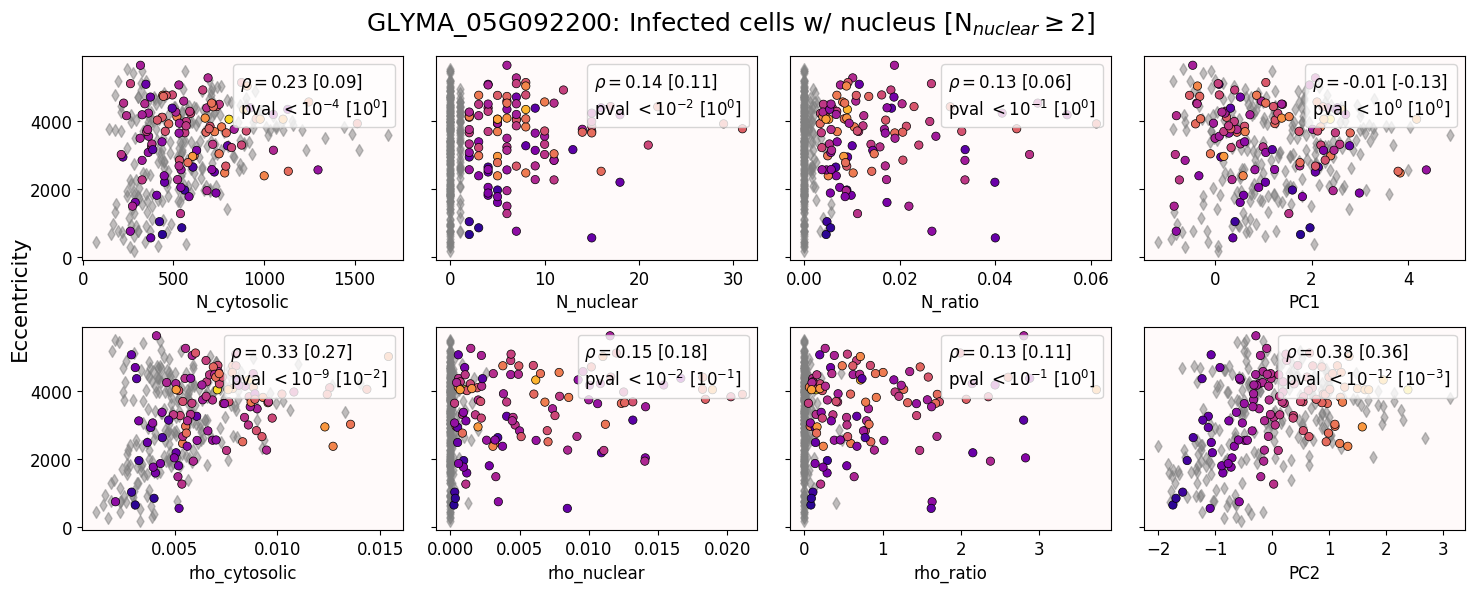

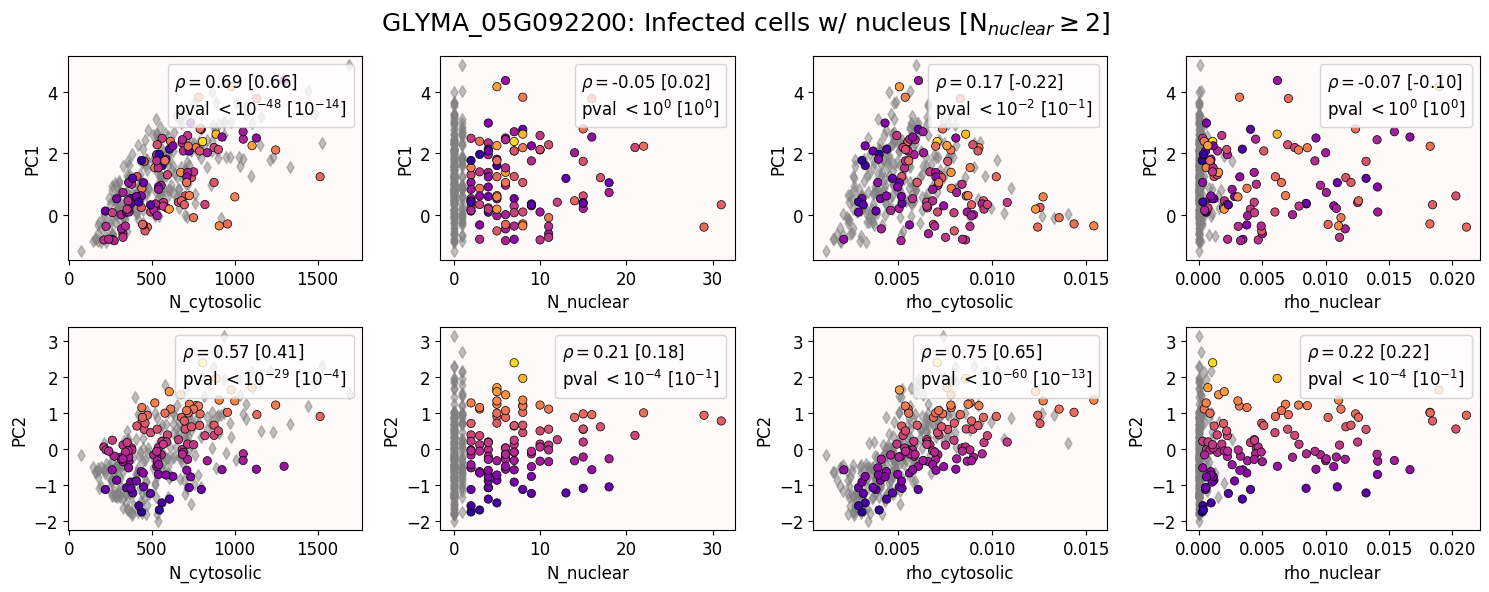

In [75]:
fs = 12
mask_val = 2
fig, ax = plt.subplots(2,4, figsize=(15,6), sharex=False, sharey=True)
ax = np.atleast_1d(ax).ravel()

c=tnum.iloc[:,7].values
vmax = utils.maximum_qq_size(c, alpha=0.25, iqr_factor=1.5)
vmin = utils.minimum_qq_size(c, alpha=0.25, iqr_factor=1.5)
mask = (tnum['N_nuclear'] >= mask_val).values

for i in range(tnum.shape[1]-1):
    colname = tnum.columns[i]

    corr0 = stats.spearmanr(tnum.loc[:,'eccentricity'], tnum.loc[:,colname])
    corr = stats.spearmanr(tnum.loc[mask,'eccentricity'], tnum.loc[mask,colname])

    expo0 = int(np.ceil(np.log10(corr0.pvalue)))
    expo = int(np.ceil(np.log10(corr.pvalue)))
    ll = '$\\rho = ${:.2f} [{:.2f}]\npval $< 10^{{{}}}$ [$10^{{{}}}$]'.format(corr0.statistic, corr.statistic, expo0, expo)
    
    ax[i].scatter(tnum.loc[~mask,colname], tnum.loc[~mask,'eccentricity'], marker='d', alpha=0.5, c='gray', zorder=2)
    ax[i].scatter(tnum.loc[mask,colname], tnum.loc[mask,'eccentricity'], marker='o', edgecolor='black', linewidth=0.5,
                  c=c[mask], cmap='plasma', label=ll, vmin=vmin, vmax=vmax, zorder=3)
    ax[i].legend(fontsize=fs, handlelength=0, handletextpad=0, loc='upper right', markerscale=0)
    
    ax[i].set_xlabel(colname, fontsize=fs)
    ax[i].tick_params(labelsize=fs)
    ax[i].set_facecolor('snow')

fig.suptitle(transcriptomes[gidx] + ': Infected cells w/ nucleus [N$_{{nuclear}}\geq${}]'.format(mask_val), fontsize=1.5*fs)
fig.supylabel('Eccentricity', fontsize=1.28*fs)
fig.tight_layout()

filename = isrc + transcriptomes[gidx] + '_ecc_infected_w_nucleus.png'
print(filename)
plt.savefig(filename, dpi=96, bbox_inches='tight', format='png')

foo = [0,1,4,5]
fig, ax = plt.subplots(2,4, figsize=(15,6), sharex=False, sharey=False)
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):

        x = tnum.columns[foo[j]]
        y = tnum.columns[4*i+3]

        corr0 = stats.spearmanr(tnum.loc[:, x].values, tnum.loc[:, y].values)
        expo0 = int(np.ceil(np.log10(corr0.pvalue)))
        corr = stats.spearmanr(tnum.loc[mask,x].values, tnum.loc[mask,y].values)
        expo = int(np.ceil(np.log10(corr.pvalue)))
        ll = '$\\rho = ${:.2f} [{:.2f}]\npval $< 10^{{{}}}$ [$10^{{{}}}$]'.format(corr0.statistic, corr.statistic, expo0, expo)

        ax[i,j].scatter(tnum.loc[~mask,x].values, tnum.loc[~mask,y].values, marker='d', c='gray', alpha=0.5, zorder=2)
        ax[i,j].scatter(tnum.loc[mask,x].values, tnum.loc[mask,y].values, marker='o', edgecolor='black', linewidth=0.5,
                        c=c[mask], cmap='plasma', label=ll, vmin=vmin, vmax=vmax, zorder=3)
        ax[i,j].legend(fontsize=fs, handlelength=0, handletextpad=0, loc='upper right', markerscale=0)
        ax[i,j].set_xlabel(x, fontsize=fs)
        ax[i,j].set_ylabel(y, fontsize=fs)
        ax[i,j].tick_params(labelsize=fs)
        ax[i,j].set_facecolor('snow')

fig.suptitle(transcriptomes[gidx] + ': Infected cells w/ nucleus [N$_{{nuclear}}\geq${}]'.format(mask_val), fontsize=1.5*fs)
fig.tight_layout();

filename = isrc + transcriptomes[gidx] + '_pca_infected_w_nucleus.png'
print(filename)
plt.savefig(filename, dpi=96, bbox_inches='tight', format='png')

../infected_focus_summer24/D2/GLYMA_05G092200_ecc_infected_wo_nucleus.png
../infected_focus_summer24/D2/GLYMA_05G092200_pca_infected_wo_nucleus.png


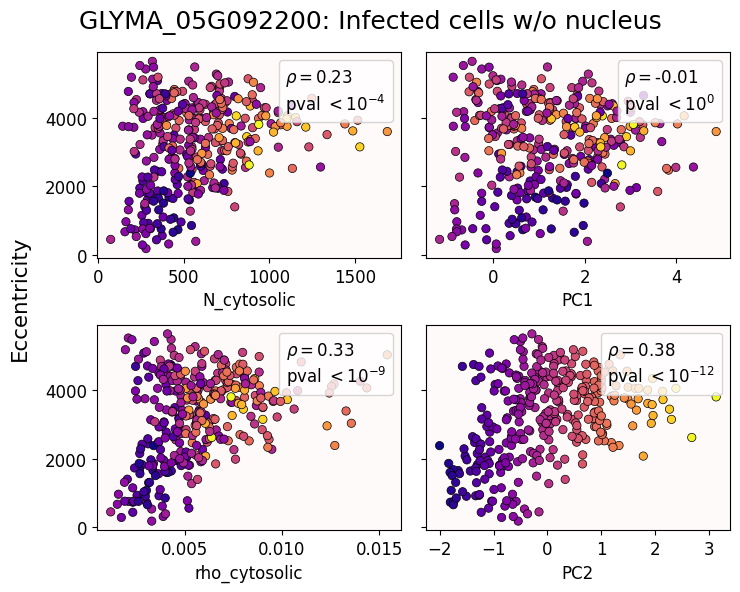

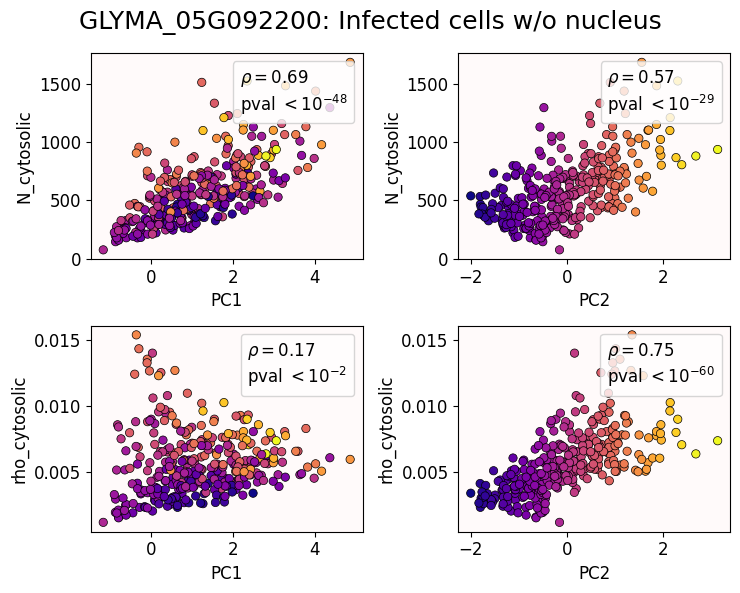

In [76]:
fs = 12
fig, ax = plt.subplots(2,2, figsize=(7.5,6), sharex=False, sharey=True)
ax = np.atleast_1d(ax).ravel()

c=tnum.iloc[:,7].values
vmax = utils.maximum_qq_size(c, alpha=0.25, iqr_factor=1.5)
vmin = utils.minimum_qq_size(c, alpha=0.25, iqr_factor=1.5)

foo = [0,3,4,7]
for i in range(len(ax)):
    colname = tnum.columns[foo[i]]
    
    corr = stats.spearmanr(tnum.loc[:,'eccentricity'], tnum.loc[:,colname])
    expo = int(np.ceil(np.log10(corr.pvalue)))
    ll = '$\\rho = ${:.2f}\npval $< 10^{{{}}}$'.format(corr.statistic, expo)
    
    ax[i].scatter(tnum.loc[:,colname], tnum.loc[:,'eccentricity'], marker='o', edgecolor='black', linewidth=0.5,
                  c=c, cmap='plasma', label=ll, vmin=vmin, vmax=vmax)
    ax[i].legend(fontsize=fs, handlelength=0, handletextpad=0, loc='upper right', markerscale=0)
    
    ax[i].set_xlabel(colname, fontsize=fs)
    ax[i].tick_params(labelsize=fs)
    ax[i].set_facecolor('snow')

fig.suptitle(transcriptomes[gidx] + ': Infected cells w/o nucleus', fontsize=1.5*fs)
fig.supylabel('Eccentricity', fontsize=1.28*fs)
fig.tight_layout()

filename = isrc + transcriptomes[gidx] + '_ecc_infected_wo_nucleus.png'
print(filename)
plt.savefig(filename, dpi=96, bbox_inches='tight', format='png')

fig, ax = plt.subplots(2,2, figsize=(7.5,6), sharex=False, sharey=False)
for i in range(2):
    for j in range(2):

        x = tnum.columns[4*j+3]
        y = tnum.columns[4*i]
        
        corr = stats.spearmanr(tnum[x].values, tnum[y].values)
        expo = int(np.ceil(np.log10(corr.pvalue)))
        ll = '$\\rho = ${:.2f}\npval $< 10^{{{}}}$'.format(corr.statistic, expo)
        
        ax[i,j].scatter(tnum[x].values, tnum[y].values, marker='o', edgecolor='black', linewidth=0.5,
                        c=c, cmap='plasma', label=ll, vmin=vmin, vmax=vmax)
        ax[i,j].legend(fontsize=fs, handlelength=0, handletextpad=0, loc='upper right', markerscale=0)
        ax[i,j].set_xlabel(x, fontsize=fs)
        ax[i,j].set_ylabel(y, fontsize=fs)
        ax[i,j].tick_params(labelsize=fs)
        ax[i,j].set_facecolor('snow')

fig.suptitle(transcriptomes[gidx] + ': Infected cells w/o nucleus', fontsize=1.5*fs)
fig.tight_layout();

filename = isrc + transcriptomes[gidx] + '_pca_infected_wo_nucleus.png'
print(filename)
plt.savefig(filename, dpi=96, bbox_inches='tight', format='png')

../infected_focus_summer24/D2/GLYMA_17G195900_ecc_all_infected.png
../infected_focus_summer24/D2/GLYMA_17G195900_pca_all_infected.png


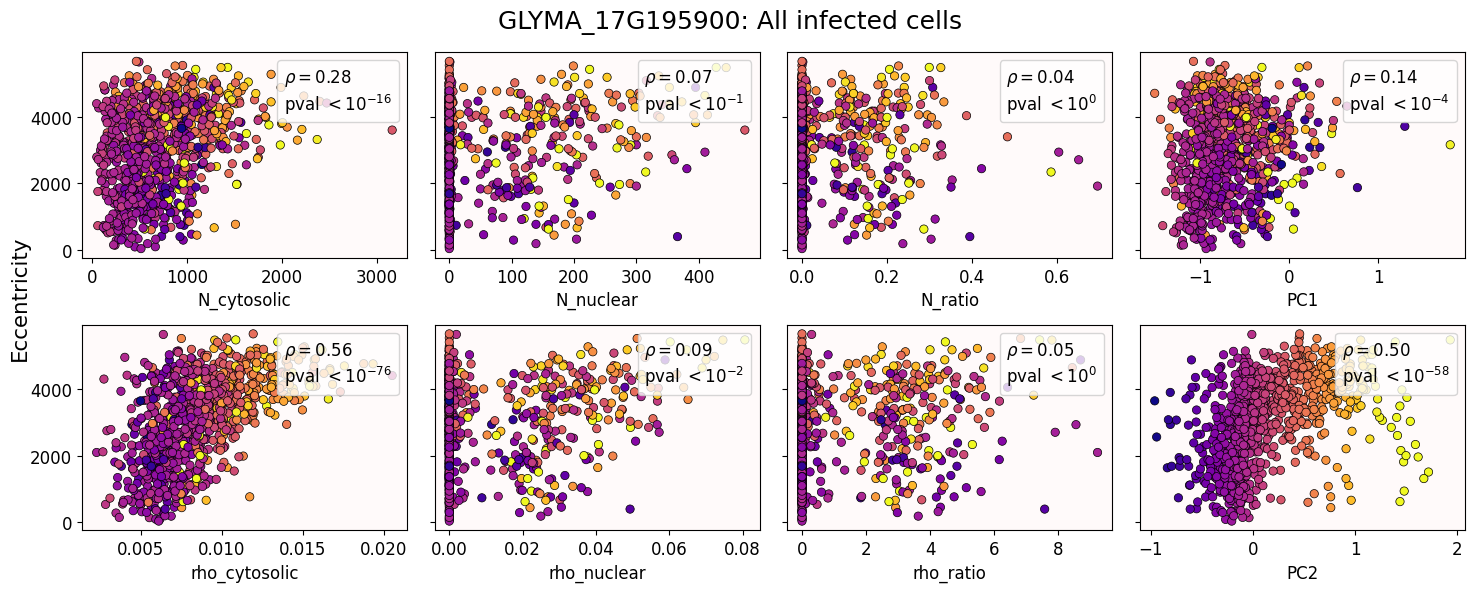

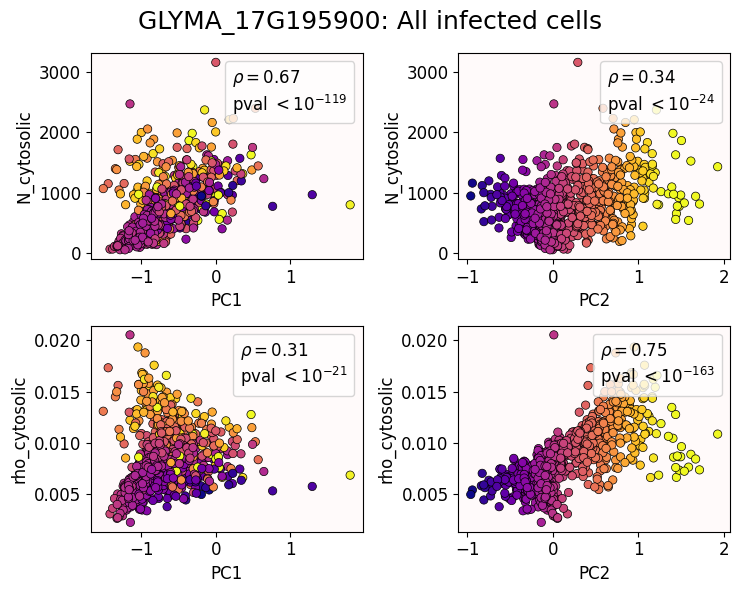

In [49]:
fig, ax = plt.subplots(2,4, figsize=(15,6), sharex=False, sharey=True)
ax = np.atleast_1d(ax).ravel()

c=tnum.iloc[:,7].values
vmax = utils.maximum_qq_size(c, alpha=0.25, iqr_factor=1.5)
vmin = utils.minimum_qq_size(c, alpha=0.25, iqr_factor=1.5)

for i in range(tnum.shape[1]-1):
    colname = tnum.columns[i]
    
    corr = stats.spearmanr(tnum.loc[:,'eccentricity'], tnum.loc[:,colname])
    expo = int(np.ceil(np.log10(corr.pvalue)))
    ll = '$\\rho = ${:.2f}\npval $< 10^{{{}}}$'.format(corr.statistic, expo)
    
    ax[i].scatter(tnum.loc[:,colname], tnum.loc[:,'eccentricity'], marker='o', edgecolor='black', linewidth=0.5,
                  c=c, cmap='plasma', label=ll, vmin=vmin, vmax=vmax)
    ax[i].legend(fontsize=fs, handlelength=0, handletextpad=0, loc='upper right', markerscale=0)
    
    ax[i].set_xlabel(colname, fontsize=fs)
    ax[i].tick_params(labelsize=fs)
    ax[i].set_facecolor('snow')

fig.suptitle(transcriptomes[gidx] + ': All infected cells', fontsize=1.5*fs)
fig.supylabel('Eccentricity', fontsize=1.28*fs)
fig.tight_layout()

filename = isrc + transcriptomes[gidx] + '_ecc_all_infected.png'
print(filename)
plt.savefig(filename, dpi=96, bbox_inches='tight', format='png')

fig, ax = plt.subplots(2,2, figsize=(7.5,6), sharex=False, sharey=False)
for i in range(2):
    for j in range(2):

        x = tnum.columns[4*j+3]
        y = tnum.columns[4*i]
        
        corr = stats.spearmanr(tnum[x].values, tnum[y].values)
        expo = int(np.ceil(np.log10(corr.pvalue)))
        ll = '$\\rho = ${:.2f}\npval $< 10^{{{}}}$'.format(corr.statistic, expo)
        
        ax[i,j].scatter(tnum[x].values, tnum[y].values, marker='o', edgecolor='black', linewidth=0.5,
                        c=c, cmap='plasma', label=ll, vmin=vmin, vmax=vmax)
        ax[i,j].legend(fontsize=fs, handlelength=0, handletextpad=0, loc='upper right', markerscale=0)
        ax[i,j].set_xlabel(x, fontsize=fs)
        ax[i,j].set_ylabel(y, fontsize=fs)
        ax[i,j].tick_params(labelsize=fs)
        ax[i,j].set_facecolor('snow')

fig.suptitle(transcriptomes[gidx] + ': All infected cells', fontsize=1.5*fs)
fig.tight_layout();

filename = isrc + transcriptomes[gidx] + '_pca_all_infected.png'
print(filename)
plt.savefig(filename, dpi=96, bbox_inches='tight', format='png')

'../infected_focus_summer24/D2/GLYMA_05G092200_infected_w_nucleus.png'

In [61]:
cell_nuc[cell_nuc['nuc_ID'] == 983]

,ndimage_ID,nuc_ID,perc_inside,N_inside,n_bot,n_top,p_bot,p_top
1250,1859,983,0.508317,36,23,25,5.978758e-06,0.000310
1281,1925,983,0.481790,73,22,39,2.925536e-08,0.000028


../infected_focus_summer24/D2/G2_sublevel_both_step3_bw30/scale16_-_PI_1_1_1_H1+2_4_GLYMA_17G195900_GLYMA_05G092200_pc_vs_pc_GLYMA_05G203100


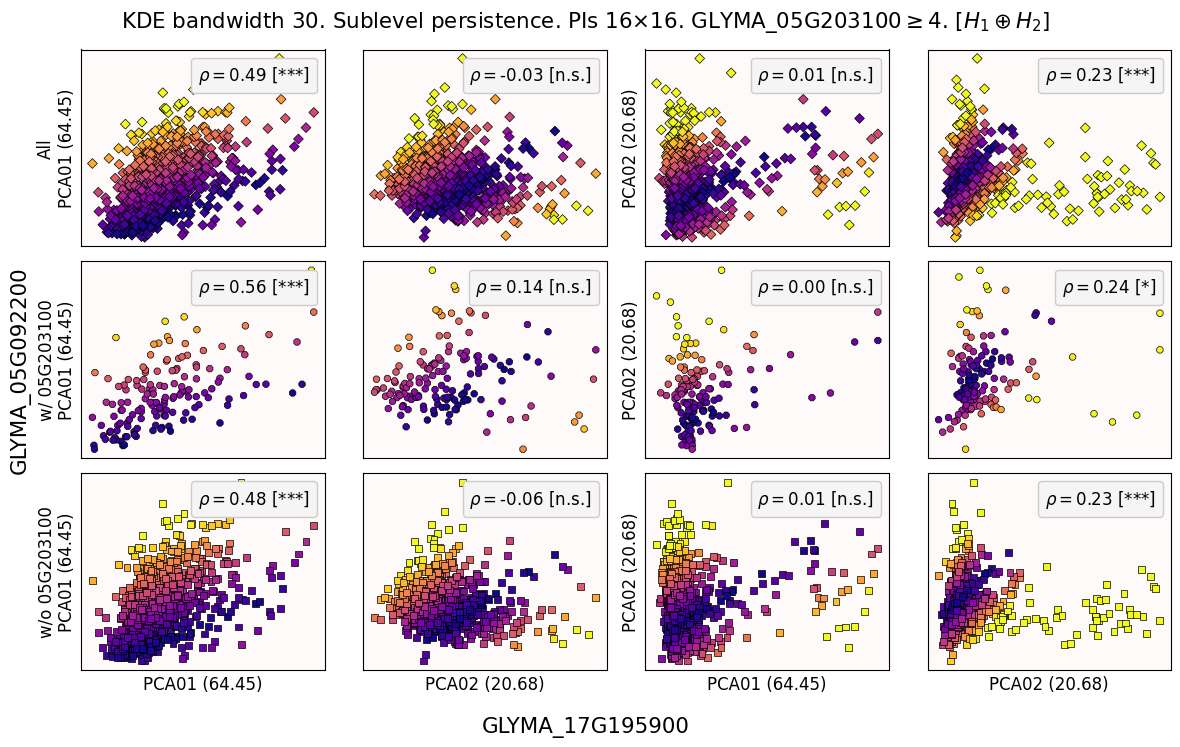

In [58]:
fig, ax = plt.subplots(3,4, figsize=(12,7.5), sharex=False, sharey=False)
for i in range(4):
    ax[-1,i].set_xlabel(embedding.columns[2+i%2], fontsize=fs)

ct = 0
for j,mask in enumerate([np.ones(len(merge),dtype=bool), O5G, nonO5G]):
    ax[j,0].set_ylabel(o5glabels[j] + '\n' +embedding.columns[2], fontsize=fs)
    ax[j,2].set_ylabel(embedding.columns[3], fontsize=fs)
    for it in itertools.product(range(2), repeat=2):
        k = 2*it[0] + it[1]
        
        pca_comp = merge.loc[mask, [ embedding.columns[2 + it[i]]+'_{}'.format(i) for i in range(2)] ]
        diff = np.abs(np.subtract(*(pca_comp.T.values)))
        vmin = utils.minimum_qq_size( diff, alpha=0.25, iqr_factor=1.5)
        vmax = utils.maximum_qq_size( diff, alpha=0.25, iqr_factor=1.5)
        
        corr = fivegdata.iloc[min5G, 12+2*ct]
        expo = utils.signifscalar(fivegdata.iloc[min5G, 12+2*ct+1])
        ct += 1
        ll = '$\\rho = ${:.2f} [{}]'.format(corr, expo)
            
        ax[j,k].scatter(pca_comp.iloc[:,0], pca_comp.iloc[:,1], c=diff, cmap='plasma', marker=marker[j],
                         edgecolor='black', linewidth=0.5, zorder=2, s=25, vmin=vmin, vmax=vmax, label=ll)
        ax[j,k].legend(fontsize=fs, handlelength=0, handletextpad=0, loc='upper right', markerscale=0, framealpha=1, facecolor='whitesmoke')

for a in ax.ravel():
    a.set_facecolor('snow')
    a.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

fig.supxlabel(transcriptomes[Genes[gi]], fontsize=1.28*fs)
fig.supylabel(transcriptomes[Genes[gj]], fontsize=1.28*fs)
fig.suptitle(Bname + Gname + Pname , fontsize=1.28*fs)

fig.tight_layout();
filename = dsrc + bname + pname + '_{}_{}_{}_pc_vs_pc_{}'.format(min5G+1, *transcriptomes[Genes[[gi,gj]]], full_id_gene)
print(filename)
#plt.savefig(filename, dpi=dpi, bbox_inches='tight', pil_kwargs={'optimize':True})

../infected_focus_summer24/D2/G2_sublevel_both_step3_bw30/scale16_-_PI_1_1_1_H1+2_1_GLYMA_17G195900_GLYMA_05G092200_ecc_GLYMA_05G203100


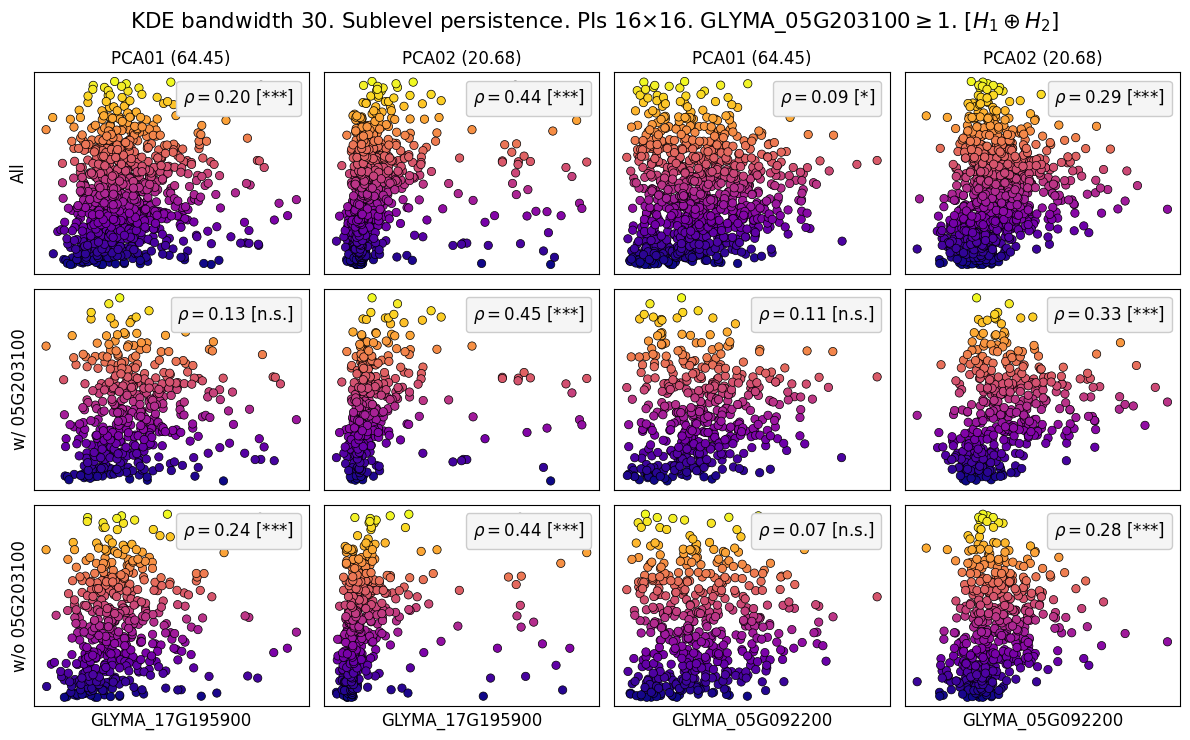

In [54]:
fig, ax = plt.subplots(3,4, figsize=(12,7.5), sharex=False, sharey=False)

for j, gidx in enumerate([gi,gj]):
    for k in range(2):
        it = (0 , 2*j+k)
        ax[it].set_title(embedding.columns[2+k], fontsize=fs)
        ax[-1, 2*j+k].set_xlabel(transcriptomes[Genes[gidx]], fontsize=fs)
ct = 0
for i,mask in enumerate([np.ones(len(merge),dtype=bool), O5G, nonO5G]):
    ax[i,0].set_ylabel(o5glabels[i], fontsize=fs)
    for j, gidx in enumerate([gi,gj]):
        pmask = embedding['gene_ID'] == Genes[gidx]
        for k in range(2):
            it = (i , 2*j+k)
            c = pca[pmask, k][mask]
            diff = np.abs(np.subtract(c, ecc[mask]))
            corr = fivegdata.iloc[min5G, 36+2*ct]
            expo = utils.signifscalar(fivegdata.iloc[min5G, 36+2*ct+1])
            ct += 1
            ll = '$\\rho = ${:.2f} [{}]'.format(corr, expo)
            ax[it].scatter(c, ecc[mask], c=diff, cmap=Cmap, marker='o', edgecolor='black', linewidth=0.5, label=ll)
            ax[it].legend(fontsize=fs, handlelength=0, handletextpad=0, loc='upper right', markerscale=0, framealpha=1, facecolor='whitesmoke')
            ax[it].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

fig.suptitle(Bname + Gname + Pname , fontsize=1.28*fs)

fig.tight_layout();
filename = dsrc + bname + pname + '_{}_{}_{}_ecc_{}'.format(min5G+1, *transcriptomes[Genes[[gi,gj]]], full_id_gene)
print(filename)
#plt.savefig(filename, dpi=dpi, bbox_inches='tight', pil_kwargs={'optimize':True})

In [249]:
bname

'scale24_-_PI_1_1_1_'

In [252]:

filename

'../infected_focus_summer24/D2/G2_sublevel_both_step3_bw15/scale24_-_PI_1_1_1_H1+2_GLYMA_17G195900_GLYMA_05G092200_ecc_GLYMA_05G203100'

# Explore